In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as spy
import seaborn as sns
import sklearn as skl

In [5]:
# Define the location of the data to be read in.
DATA_PATH = '~/Documents/DS/Data/kic/'

In [6]:
# Set data variables
training_data = pd.read_csv(DATA_PATH + 'exoTrain.csv')
testing_data = pd.read_csv(DATA_PATH + 'exoTest.csv')

In [7]:
# Seperate features (time series) from target (label)
target = 'LABEL'

In [12]:
# Define functions to do forward fourier transformation
def ft(x):
    y = spy.fft(x, n= x.size)
    return np.abs(y)
    
def spectrum_transform(X):
    X = X.copy()
    X = X.div(X.sum(axis=1), axis=0)
    X = X.apply(ft, axis=1)
    X = pd.DataFrame.from_records(X.iloc[[x for x in range(len(X))]])
    
    ### The spectra are perfectly symmetrical, so cut them in half to reduct dimensionality ###
    half = len(X.columns) // 2
    X = X.loc[:,half:]
    return X

In [13]:
# Apply transformation to training and testing data
train = spectrum_transform(training_data.drop(columns=target))
test = spectrum_transform(testing_data.drop(columns=target))

In [29]:
# Get target vectors
y_train = training_data[target]
y_test = testing_data[target]

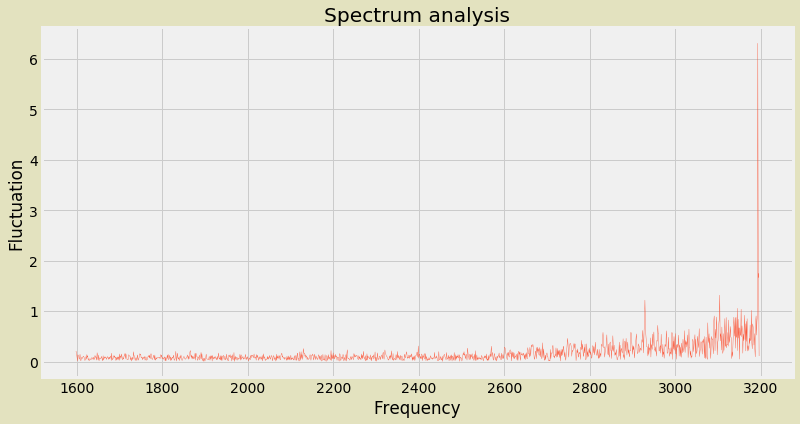

In [26]:
# Plot first line from training data to ensure spectrum data looks correct
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(12,6), facecolor='#e3e2bf')

ax = plt.plot(train.iloc[0], linewidth=0.35, color='C1')
plt.title('Spectrum analysis')
plt.ylabel('Fluctuation')
plt.xlabel('Frequency')
plt.show()

In [22]:
# Oversample the training data
from imblearn.over_sampling import SMOTE

In [31]:
# Oversampling
sample = SMOTE(sampling_strategy='minority', random_state=42, )
train_xres, train_yres = sample.fit_resample(train, y_train)

In [106]:
train_xres = pd.DataFrame(train_xres, columns=train.columns)

In [66]:
# Attempt a standard randomforest classifier
rf_model = skl.ensemble.RandomForestClassifier(n_estimators = 100, max_depth = 7, random_state=42, n_jobs=-1)
rf_model.fit(train_xres, train_yres)
y_pred = rf_model.predict(test)
y_pred = pd.Series(y_pred)

# View Details of the results

In [67]:
y_test[y_test == 2]

0    2
1    2
2    2
3    2
4    2
Name: LABEL, dtype: int64

In [69]:
y_pred[y_pred == 2]

1      2
4      2
332    2
487    2
513    2
dtype: int64

## How did the Random Forest model do?

In [73]:
print('The precision of the Random Forest model is low, at just',(2/5)*100,'%')
print("Recall is exactly the same.")
print("False positives predicted at",(3/5)*100,'%')

The precision of the Random Forest model is low, at just 40.0 %
Recall is exactly the same.
False positives predicted at 60.0 %


In [74]:
print(skl.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       565
           2       0.40      0.40      0.40         5

    accuracy                           0.99       570
   macro avg       0.70      0.70      0.70       570
weighted avg       0.99      0.99      0.99       570



# Test XGBClassifier to see if it can do any better

In [75]:
import xgboost as xgb

In [114]:
boost_model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.15, max_depth=5)

In [115]:
eval_set = [(test, y_test)]
boost_model.fit(train_xres, train_yres, early_stopping_rounds=25, eval_metric='aucpr', eval_set=eval_set)

[0]	validation_0-aucpr:0.19431
Will train until validation_0-aucpr hasn't improved in 25 rounds.
[1]	validation_0-aucpr:0.138637
[2]	validation_0-aucpr:0.103929
[3]	validation_0-aucpr:0.122722
[4]	validation_0-aucpr:0.171816
[5]	validation_0-aucpr:0.162492
[6]	validation_0-aucpr:0.335921
[7]	validation_0-aucpr:0.369935
[8]	validation_0-aucpr:0.378988
[9]	validation_0-aucpr:0.382464
[10]	validation_0-aucpr:0.398278
[11]	validation_0-aucpr:0.408061
[12]	validation_0-aucpr:0.407755
[13]	validation_0-aucpr:0.406133
[14]	validation_0-aucpr:0.405735
[15]	validation_0-aucpr:0.406348
[16]	validation_0-aucpr:0.406063
[17]	validation_0-aucpr:0.430357
[18]	validation_0-aucpr:0.446922
[19]	validation_0-aucpr:0.537989
[20]	validation_0-aucpr:0.573768
[21]	validation_0-aucpr:0.576712
[22]	validation_0-aucpr:0.586992
[23]	validation_0-aucpr:0.505578
[24]	validation_0-aucpr:0.586671
[25]	validation_0-aucpr:0.58803
[26]	validation_0-aucpr:0.58767
[27]	validation_0-aucpr:0.587324
[28]	validation_0-aucpr

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [116]:
y_pred = boost_model.predict(test)

In [119]:
print(skl.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       565
           2       0.60      0.60      0.60         5

    accuracy                           0.99       570
   macro avg       0.80      0.80      0.80       570
weighted avg       0.99      0.99      0.99       570



## Re-run the test, tracking train and validation

In [472]:
boost_model2 = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.25, max_depth=3, random_state=42)
eval_set2 = [(train, y_train),(test, y_test)]
boost_model2.fit(train_xres, train_yres, early_stopping_rounds=25, eval_metric='aucpr', eval_set=eval_set2)

[0]	validation_0-aucpr:0.093434	validation_1-aucpr:0.038768
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr hasn't improved in 25 rounds.
[1]	validation_0-aucpr:0.317825	validation_1-aucpr:0.10486
[2]	validation_0-aucpr:0.691998	validation_1-aucpr:0.252463
[3]	validation_0-aucpr:0.731783	validation_1-aucpr:0.436667
[4]	validation_0-aucpr:0.787892	validation_1-aucpr:0.441265
[5]	validation_0-aucpr:0.811447	validation_1-aucpr:0.482091
[6]	validation_0-aucpr:0.828308	validation_1-aucpr:0.469717
[7]	validation_0-aucpr:0.896721	validation_1-aucpr:0.523861
[8]	validation_0-aucpr:0.929397	validation_1-aucpr:0.492923
[9]	validation_0-aucpr:0.943433	validation_1-aucpr:0.502403
[10]	validation_0-aucpr:0.961954	validation_1-aucpr:0.476969
[11]	validation_0-aucpr:0.971942	validation_1-aucpr:0.484501
[12]	validation_0-aucpr:0.977859	validation_1-aucpr:0.462266
[13]	validation_0-aucpr:0.983276	validation_1-aucpr:0.458

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.25, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# Explaination for this cell:

> The following cell illustrates a procedure that may seem a bit unorthodox. At it's surface, this code takes the predicted probability from the model and if that values is greater than 5%, returns a positive prediction class (2). It may seem at first counter intuitive to take such small percentages to assume a positive prediction, but this is done for a couple of reasons.

> The model generally appears to be very sure, with most of the data, on if it thinks there is a transit or not. Most prediction probabilities range around 95 - 99%. Because the model is generally very confident about non-transits, whenever there is a little uncertainty, that indicates that signals for transit may be present.

> Because the model is tree based, it is very hard to figure out new transit signals. On the other hand, negative transit signals are available in abundance. Therefore, the likelyhood of a false negative is extremely low. By ruling out what the model knows is negative, we can hone in on what is positive. The false positive rate will be high, but the idea is that recall should be at or very near zero.

> It may be possible to take the positives and filter further with different transformations. This will be explored further.

In [480]:
y_pred2 = boost_model2.predict_proba(test)

y_pred3 = []
for x, y in y_pred2:
    if y >= 0.01:
        y_pred3.append(2)
    else:
        y_pred3.append(1)
        
print(skl.metrics.classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           1       1.00      0.89      0.94       565
           2       0.08      1.00      0.14         5

    accuracy                           0.89       570
   macro avg       0.54      0.95      0.54       570
weighted avg       0.99      0.89      0.94       570



## As expected, recall is at 1, with a very low (relative) precision.

### Here is a plot of the AUC/PR score curve

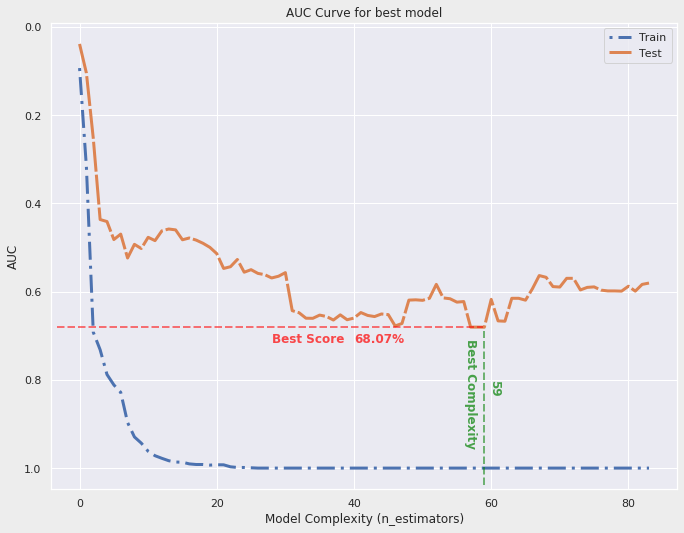

In [505]:
# Plot the model scores
train_score = boost_model2.evals_result()['validation_0']['aucpr']
test_score = boost_model2.evals_result()['validation_1']['aucpr']
est_index = [index for index, value in enumerate(test_score) if value == max(test_score)]

fig = plt.figure(figsize=(10,8), facecolor='#ededed')
plt.plot(train_score, color='C0', label='Train', dashes=([1,2,6,2]), linewidth=3)
plt.plot(test_score, color='C1', label='Test', dashes=([10,1]), linewidth=3)
plt.axhline(max(test_score), 0.01, 0.69, color='red', linewidth=1.5, dashes=(5,2), alpha=.7)
plt.axvline(est_index, 0.01, 0.339, color='green', linewidth=1.5, dashes=(5,2), alpha=.7)
plt.text(28, 0.715, s="Best Score", color='Red', alpha=.7, fontweight='bold')
plt.text(56, 0.95, s='Best Complexity', rotation=-90, color='green', alpha=.7, fontweight='bold')
plt.text(40, 0.715, s='{:.2f}%'.format(max(test_score)*100), color='red', alpha=.7, fontweight='bold')
plt.text(59.5, 0.83, s=est_index[0], rotation=-90, color='green', alpha=.7, fontweight='bold')
plt.title('AUC Curve for best model')
plt.ylabel('AUC')
plt.xlabel('Model Complexity (n_estimators)')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [482]:
# I have to do this crazy calculations because python thinks 112 / 565 is 22.4. Not even close.
cm1 = skl.metrics.confusion_matrix(y_test, y_pred3)
row0 = cm1[[0]].sum()
row1 = cm1[[1]].sum()

cm_final = np.array(
    [[cm1[0,0]/row0*100,
      cm1[0,1]/row0*100],
     [cm1[1,0]/row1*100,
      cm1[1,1]/row1*100]]
)
print(cm_final)

[[ 89.38053097  10.61946903]
 [  0.         100.        ]]


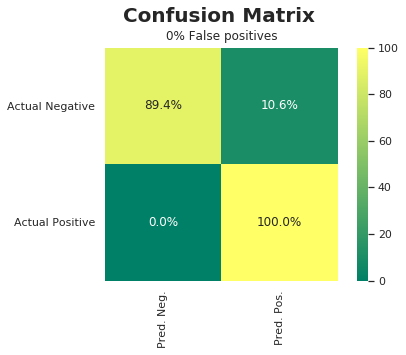

In [483]:
sns.set()
fig, ax0 = plt.subplots(1,1)
plt.suptitle('Confusion Matrix', fontsize=20, y=1.02, fontweight='bold')
plt.title('0% False positives', y=1.005)
ax = sns.heatmap(cm_final, annot=True, fmt='.1f', square=True, cmap='summer')
# matplotlib <=> seaborn fixes
plt.yticks([1.5, 0.5], labels=['Actual Positive', 'Actual Negative'], rotation=0)
plt.xticks([0.5, 1.5], labels=['Pred. Neg.', 'Pred. Pos.'], rotation=90)
plt.gca().set_ylim(2, 0)
# fix % to annotations
for t in ax.texts: t.set_text(t.get_text() + '%')
plt.show()